## Предобработка данных

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
matplotlib.rcParams['figure.figsize'] =  [15.0, 8.0]


Цель - смоделировать частоту убытка и его среднюю величину

In [6]:
# Загрузим набор данных
path = 'C:/Users/user/Documents/mydocs/gb_timeseries/insurance/data/'
df = pd.read_csv(path+'freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
Exposure             115155 non-null float64
LicAge               115155 non-null int64
RecordBeg            115155 non-null object
RecordEnd            59455 non-null object
Gender               115155 non-null object
MariStat             115155 non-null object
SocioCateg           115155 non-null object
VehUsage             115155 non-null object
DrivAge              115155 non-null int64
HasKmLimit           115155 non-null int64
BonusMalus           115155 non-null int64
ClaimAmount          115155 non-null float64
ClaimInd             115155 non-null int64
ClaimNbResp          115155 non-null float64
ClaimNbNonResp       115155 non-null float64
ClaimNbParking       115155 non-null float64
ClaimNbFireTheft     115155 non-null float64
ClaimNbWindscreen    115155 non-null float64
OutUseNb             115155 non-null float64
RiskArea             115155 non-null float64
dtypes

In [7]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
1,0.916,333,2004-02-01,NaN,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
3,0.089,364,2004-11-29,NaN,Female,Other,CSP55,Private+trip to office,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


Exposure - доля года,  за который полис действовал 
DrivAge - возраст
SocioCateg - социальная категория 
Gender - пол 
MariStat - семейный статус 
VehUsage - тип использования транспортного средства 
ClaimInd  - случилось страховое событие или нет
ClaimAmount - величина убытка 
Виды ущербов -  ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen")

## первые наблюдения

1 ) Есть строковые переменные, которые мы не можем использовать - object

2 ) В предыдущем уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [8]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [9]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

## перекодируем бинарные  переменные типа `object` с помощью числовых значений

In [10]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [11]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [12]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


## перекодируем небинарные категориальные признаки с помощью числовых значений

Для переменных, содержащих более 2 значений, различия между которыми не могут упорядочены, используем фиктивные переменные (one-hot encoding).

**NB**: В H2O не рекомендуется использовать one-hot encoding, поскольку данный фреймворк корректно работает с категориальными признаками, тогда как применение one-hot encoding приводит к неэффективности. Тем не менее, используем здесь фиктивные переменные, чтобы в дальнейшем сохранить возможность сравнения результатов построенных моделей.

In [13]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [14]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [15]:
df['SocioCateg'].unique()

array(['CSP50', 'CSP55', 'CSP60', 'CSP48', 'CSP6', 'CSP66', 'CSP1',
       'CSP46', 'CSP21', 'CSP47', 'CSP42', 'CSP37', 'CSP22', 'CSP3',
       'CSP49', 'CSP20', 'CSP2', 'CSP40', 'CSP7', 'CSP26', 'CSP65',
       'CSP41', 'CSP17', 'CSP57', 'CSP56', 'CSP38', 'CSP51', 'CSP59',
       'CSP30', 'CSP44', 'CSP61', 'CSP63', 'CSP45', 'CSP16', 'CSP43',
       'CSP39', 'CSP5', 'CSP32', 'CSP35', 'CSP73', 'CSP62', 'CSP52',
       'CSP27', 'CSP24', 'CSP19', 'CSP70'], dtype=object)

In [16]:
#выделим только первые 4 знака, чтобы сократить количество социальных категорий

In [17]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [18]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [19]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

Теперь, когда большинство переменных типа `object` обработаны, исключим их из набора данных за ненадобностью.

In [20]:
df = df.select_dtypes(exclude=['object'])

In [21]:
## Feature engineering 

Также создадим такую переменную, как квадрат возраста.
Почему - так как возраст влияет на частоту возникновения страховых случаем 
например высокая частота для молодых и с возрастом выше среднего 

In [22]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,...,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,...,0,0,0,0,0,0,0,1,0,3249


## формируем индикатор убытков - целевую переменную

Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [23]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [24]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


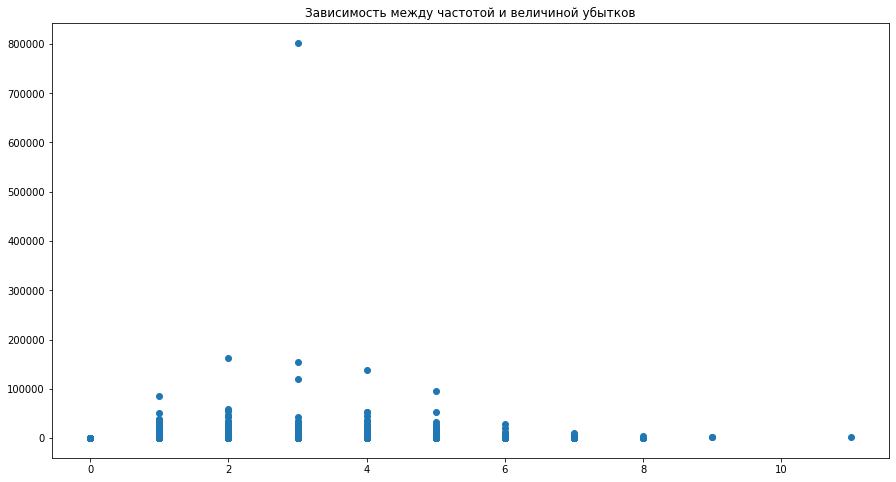

In [25]:
plt.scatter(df['ClaimsCount'], df['ClaimAmount']) 
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [26]:
dfAC = df[df.ClaimsCount > 0].copy()
dfAC['AvgClaim'] = dfAC.ClaimAmount/dfAC.ClaimsCount #средний убыток - вторая целевая переменнная

In [28]:
dfAC.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,...,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq,ClaimsCount,AvgClaim
33,0.617,602,0,0,68,0,50,5377.204532,1,0.0,...,0,0,0,0,0,1,0,4624,4.0,1344.301133
34,0.761,357,1,1,47,0,50,2017.843505,1,0.0,...,0,0,0,0,1,0,0,2209,2.0,1008.921752
53,0.023,271,0,0,49,0,50,356.773414,1,2.0,...,0,0,0,0,1,0,0,2401,2.0,178.386707
65,0.833,539,0,0,75,0,50,645.125982,1,0.0,...,0,0,0,0,0,1,0,5625,1.0,645.125982
66,0.957,302,1,0,49,0,54,1200.422356,1,0.0,...,0,0,0,0,1,0,0,2401,2.0,600.211178


## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [29]:
from sklearn.model_selection import train_test_split

разбиваем на две части по двум целевым переменным: 1) частота и 2) средний убыток 

In [30]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), df.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [31]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(dfAC.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount', 'AvgClaim'], axis=1), dfAC.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

## Обобщенные линейные модели (Generalized Linear Models, GLM)

### Теория

Пусть $y$ – целевая переменная, $X$ – матрица объясняющих переменных, $\beta$ – вектор параметров модели.

Матрица $X$ составлена из всех векторов наблюдений $x_i$, каждый из которых представляет собой объясняющую переменную.

Основные компоненты обобщенной линейной модели:
* Систематическая компонента $\eta$:
    * $\eta = X\beta \hspace{10pt}(=\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_nx_n)$.
* Случайная компонента $y$:
    * Элементы вектора $y$ – независимые одинаково распределенные случайные величины, имеющие функцию плотности распределения $f(y;\theta,\phi)$ из экспоненциального семейства.
    * Распределения из экспоненциального семейства имеют параметры $\theta$ (характеристика среднего) и $\phi$ (характеристика дисперсии). В общем виде данные распределения могут быть определены:
    $$f_i(y_i;\theta_i,\phi)=\exp\left\lbrace \frac{y_i\theta_i-b(\theta_i)}{a_i(\phi)} + c(y_i, \phi) \right\rbrace,$$
    где $a_i(\phi)$, $b(\theta_i)$ и $c(y_i, \phi)$ некоторые функции.
    * Для распределений из данного семейства дисперсия является функцией от среднего.
    * Экспоненциальное семейство включает распределения нормальное, экспоненциальное, Пуассона, гамма, хи-квадрат, бета и другие.
* Функция связи $g$:
    * $\mathbb{E}\left[y\right]=\mu=g^{-1}\left(\eta\right)$, $\mu$ – математическое ожидание $y$;
    * $g$ – монотонная дифференцируемая функция.




#### GLM с распределением Пуассона

Регрессия Пуассона обычно используется в случаях, когда зависимая переменная представляет собой счетные значения и ошибки предполагаются распределенными в соответствии с распределением Пуассона. Зависимая переменная должна быть неотрицательной.

Функции связи между таргетом и объясняющими переменными предполагается логарифмической:
$$g(\eta) = \ln(\eta) \Rightarrow \hat {y} = e^{x{^T}\beta + {\beta_{0}}}.$$

Модель оценивается методом максимального правдоподобия, функция логарифма правдоподобия с учетом штрафа регуляризации эластичной сети имеет вид:
$$\max_{\beta,\beta_0} \frac{1}{N} \sum_{i=1}^{N} \Big( y_i(x_{i}^{T}\beta + \beta_0) - e^{x{^T_i}\beta + {\beta_0}} \Big)- \lambda \Big( \alpha||\beta||_1 + \dfrac {1} {2}(1 - \alpha)||\beta||^2_2 \Big),$$

где 
* $\lambda$ – параметр, отвечающий за силу регуляризации. $\lambda\in\mathbb{R}^{+}$;
* $\alpha$ – параметр, отвечающий за распределение штрафов регуляризации между нормой 1 ($\ell_1$) и нормой 2 ($\ell_2$). $\alpha\in[0,1]$;
* $||\beta||{_1}$ – штраф регуляризации $\ell_1$ (LASSO). $||\beta||{_1} = \sum{^p_{k=1}} |\beta{_k}|$;
* $||\beta||{_2}$ – штраф регуляризации $\ell_2$ (Ridge). $||\beta||{_2} = \sum{^p_{k=1}} \beta{^2_k}$.

Тогда соответствующая метрика _Deviance_ имеет вид:
$$D = -2 \sum_{i=1}^{N} \big( y_i \text{ln}(y_i / \hat {y}_i) - (y_i - \hat {y}_i) \big).$$

##### Вывод функции правдоподобия для GLM с распределением Пуассона (без регуляризации)

**NB:** Ниже $\lambda$ не имеет отношения к вышеупомянутому одноименному параметру регуляризации.

Напомним, что функция вероятности для распределения Пуассона имеет вид:
$$p(k;\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}, \hspace{10pt} \lambda\in\mathbb{R}^{+}.$$
Также, для распределения Пуассона справедливо, что:
$$\mathbb{E}\left[k\right] = Var(k) = \lambda.$$
Тогда, для оценивания коэффициентов нашей модели необходимо максимизировать правдоподобие (совместную условную вероятность при имеющихся данных), что данные имеют распределение Пуассона:
$$p(y_1,\dots,y_n|x_1,\dots,x_n;\beta_0,\beta) = \prod_{i=1}^{N}\frac{e^{y_i(x_i{^T}\beta + {\beta_{0}})} e^{-e^{x_i{^T}\beta + {\beta_{0}}}}}{y_i!} = L(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n).$$
Для упрощения задачи оптимизации перейдем к логарифму правдоподобия:
$$\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) = \sum_{i=1}^{N}\left(y_i(x_i{^T}\beta + {\beta_{0}}) -e^{x_i{^T}\beta + {\beta_{0}}}-\ln(y_i!)\right).$$
Поскольку величина $\ln(y_i!)$ не зависит от выбора параметров, можно упростить задачу:
$$\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) = \sum_{i=1}^{N}\left(y_i(x_i{^T}\beta + {\beta_{0}}) -e^{x_i{^T}\beta + {\beta_{0}}}\right).$$
Далее численно решается задача оптимизации для определения параметров модели:
$$\frac{\partial \ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n)}{\partial \beta_0} = 0,\\\frac{\partial \ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n)}{\partial \beta} = 0.$$
Обычно минимизируется отрицательное правдоподобие, которое является выпуклой функцией.

##### Вывод метрики Deviance для GLM с распределением Пуассона

Метрика Deviance представляет собой отношение правдоподобия между двумя моделями: рассматриваемой моделью и "идеальной" моделью, в которая бы идеально предсказывала бы зависимую переменную.
$$Deviance = 2(\ell_{ideal} - \ell_{model})$$

В качестве такой "идеальной модели" может использоваться сама зависимая переменная. Тогда, логарифм правдоподобия "идеальной модели" для GLM с распределением Пуассона имеет вид:
$$\ell_{ideal} = \sum_{i=1}^{N}\left(y_i \ln(y_i) -y_i-\ln(y_i!)\right).$$

Из приведенного выше вывода правдоподобия для рассматриваемой модели, мы можем записать, обозначив $\hat{y}_i = e^{x{^T}\beta + {\beta_{0}}}$:
$$\ell_{model} = \sum_{i=1}^{N}\left(y_i \ln(\hat{y}_i) -\hat{y}_i-\ln(y_i!)\right).$$

Тогда получаем,
$$Deviance = 2\sum_{i=1}^{N}\left(y_i \ln(y_i) -y_i - y_i \ln(\hat{y}_i) +\hat{y}_i\right) = -2\sum_{i=1}^{N}\left(y_i \ln(y_i/\hat{y}_i) - (y_i -\hat{y}_i)\right).$$


#### GLM с гамма-распределением

GLM с гамма-распределением используется для моделирования положительной непрерывной зависимой переменной, когда ее условная дисперсия увеличивается вместе со средним значением, но коэффициент вариации зависимой переменной предполагается постоянным.

Обычно GLM с гамма-распределением используются с логарифмической или обратной функциями связи:
$$g(\eta) = \ln(\eta);\hspace{20pt}g(\eta) = \frac{1}{\eta}.$$

Модель оценивается методом максимального правдоподобия, функция логарифма правдоподобия (для обратной функции связи) с учетом штрафа регуляризации эластичной сети имеет вид:
$$\max_{\beta,\beta_0} - \frac{1}{N} \sum_{i=1}^{N} \frac{y_i}{x{^T_i}\beta + \beta_0} + \text{ln} \big( x{^T_i}\beta + \beta_0 \big ) - \lambda \Big( \alpha||\beta||_1 + \dfrac {1} {2}(1 - \alpha)||\beta||^2_2 \Big),$$

где 
* $\lambda$ – параметр, отвечающий за силу регуляризации. $\lambda\in\mathbb{R}^{+}$;
* $\alpha$ – параметр, отвечающий за распределение штрафов регуляризации между нормой 1 ($\ell_1$) и нормой 2 ($\ell_2$). $\alpha\in[0,1]$;
* $||\beta||{_1}$ – штраф регуляризации $\ell_1$ (LASSO). $||\beta||{_1} = \sum{^p_{k=1}} |\beta{_k}|$;
* $||\beta||{_2}$ – штраф регуляризации $\ell_2$ (Ridge). $||\beta||{_2} = \sum{^p_{k=1}} \beta{^2_k}$.

Соответствующая метрика _Deviance_ имеет вид:
$$D = 2 \sum_{i=1}^{N} - \text{ln} \bigg (\dfrac {y_i} {\hat {y}_i} \bigg) + \dfrac {(y_i - \hat{y}_i)} {\hat {y}_i}.$$




##### Вывод функции правдоподобия для GLM с Гамма-распределением и логарифмической функцией связи (без регуляризации)

**NB:** Ниже $\alpha$ и $\lambda$ не имеют отношения к вышеупомянутым одноименным параметрам регуляризации.

Напомним, что функция плотности вероятности для Гамма-распределения имеет вид:
$$f(x;\alpha,\lambda) = 
\begin{cases}
\frac{\alpha^\lambda}{\Gamma(\lambda)}x^{\lambda-1}e^{-\alpha x},&x \ge 0\\
0,& x <0
\end{cases},\hspace{20pt} \Gamma(x) = \int_0^{\infty}x^{\lambda-1}e^{-x}dx.
$$
Также, для Гамма-распределения справедливо, что:
$$ \mathbb{E}[x] = \frac{\lambda}{\alpha},\hspace{15pt} Var(x) = \frac{\lambda}{\alpha^2}.$$

Для оценивания GLM удобно параметризовать данное распределение иначе:
$$ \mathbb{E}[x] = \frac{\lambda}{\alpha} = \mu,\hspace{15pt} Var(x) = \frac{\lambda}{\alpha^2} = \frac{\mu^2}{\lambda}.$$
Тогда,
$$f(x;\mu,\lambda) = \frac{1}{\Gamma(\lambda)}\alpha^\lambda x^{\lambda-1}e^{-\alpha x} = \frac{1}{\Gamma(\lambda)}\left(\frac{\lambda}{\mu}\right)^\lambda x^{\lambda-1}e^{-\left(\frac{\lambda}{\mu}\right)x} = \frac{1}{x\cdot\Gamma(\lambda)}\left(\frac{\lambda x}{\mu}\right)^\lambda e^{-\frac{\lambda x}{\mu}},\hspace{15pt} x\ge 0.$$

Также напомним, что для GLM с функцией связи $\ln(x)$ предсказание (оценка математического ожидания) имеет вид $\hat {y} = e^{x{^T}\beta + {\beta_{0}}}$.


Тогда, для оценивания коэффициентов нашей модели необходимо максимизировать правдоподобие (совместную условную вероятность при имеющихся данных), что данные имеют Гамма-распределение, в предположении известного параметра $\lambda$:
$$p(y_1,\dots,y_n|x_1,\dots,x_n;\beta_0,\beta) = \prod_{i=1}^{N}\frac{1}{y_i\cdot\Gamma(\lambda)}\left(\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right)^\lambda e^{-\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}} = L(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n).$$
Для упрощения задачи оптимизации перейдем к логарифму правдоподобия:
\begin{align}
\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) &= \sum_{i=1}^{N}\left(-\ln(\Gamma(\lambda))-\ln(y_i)+ \lambda\ln\left(\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right) -\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right)\\ &= \sum_{i=1}^{N}\left(-\ln(\Gamma(\lambda))-\ln(y_i) + \lambda\ln\left(\lambda\right)+\lambda\ln\left(y_i\right)-\lambda\left({x_i{^T}\beta + {\beta_{0}}}\right) -\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right)\\ &= \sum_{i=1}^{N}\left((\lambda-1)\ln\left(y_i\right)-\ln(\Gamma(\lambda)) + \lambda\ln\left(\lambda\right)-\lambda\left({x_i{^T}\beta + {\beta_{0}}}\right) -\frac{\lambda y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right).
\end{align}
Тогда обозначим слагаемые, не зависящие от параметров модели ($\beta_0$, $\beta$), как некоторую константу $C$, получаем:
$$\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) = \sum_{i=1}^{N}\left(-\lambda\left(\left({x_i{^T}\beta + {\beta_{0}}}\right) +\frac{y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right) + C(y_i, \lambda)\right),$$
Таким образом, требуется максимизировать
$$\ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n) = -\sum_{i=1}^{N}\left(\left({x_i{^T}\beta + {\beta_{0}}}\right) + \frac{y_i}{e^{x_i{^T}\beta + {\beta_{0}}}}\right),$$
Далее численно решается задача оптимизации для определения параметров модели:
$$\frac{\partial \ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n)}{\partial \beta_0} = 0,\\\frac{\partial \ell(\beta_0,\beta|y_1,\dots,y_n,x_1,\dots,x_n)}{\partial \beta} = 0.$$
Обычно минимизируется отрицательное правдоподобие, которое является выпуклой функцией.

##### Вывод метрики Deviance для GLM с Гамма-распределением

Метрика Deviance представляет собой отношение правдоподобия между двумя моделями: рассматриваемой моделью и "идеальной" моделью, в которая бы идеально предсказывала бы зависимую переменную.
$$Deviance = 2(\ell_{ideal} - \ell_{model})$$

В качестве такой "идеальной модели" может использоваться сама зависимая переменная. Тогда, логарифм правдоподобия "идеальной модели" для GLM с распределением Пуассона имеет вид:
$$\ell_{ideal} = -\sum_{i=1}^{N}\left(1 + \ln(y_i)\right).$$

Из приведенного выше вывода правдоподобия для рассматриваемой модели, мы можем записать, обозначив $\hat{y}_i = e^{x{^T}\beta + {\beta_{0}}}$:
$$\ell_{model} = -\sum_{i=1}^{N}\left(\frac{y_i}{\hat{y}_i} + \ln(\hat{y}_i)\right).$$

Тогда получаем,
$$Deviance = 2\sum_{i=1}^{N}\left(- 1 - \ln(y_i) + \frac{y_i}{\hat{y}_i} + \ln(\hat{y}_i)\right) = 2\sum_{i=1}^{N}\left(-\ln\left(\frac{y_i}{\hat{y}_i}\right)+\frac{y_i-\hat{y}_i}{\hat{y}_i} \right).$$

#### Дополнительная литература по GLM

*   [P. McCullagh, John A. Nelder _"Generalized Linear Models"_](http://www.utstat.toronto.edu/~brunner/oldclass/2201s11/readings/glmbook.pdf)
*   [D. Anderson, et al. _"A practitioner’s guide to generalized linear models"_](https://www.casact.org/pubs/dpp/dpp04/04dpp1.pdf)
*   [E. Ohlsson, B. Johansson _"Non-life insurance pricing with generalized linear models"_](https://www.springer.com/gp/book/9783642107900)
*   [P. De Jong, G. Heller _"Generalized linear models for insurance data"_](https://feb.kuleuven.be/public/u0017833/boek.pdf)




### Установка H2O на Google Colaboratory и инициализация

In [38]:
#!apt-get install default-jre

In [32]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.7+8-LTS, mixed mode)
  Starting server from C:\Users\user\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\user\AppData\Local\Temp\tmpc21sspi5
  JVM stdout: C:\Users\user\AppData\Local\Temp\tmpc21sspi5\h2o_user_started_from_python.out
  JVM stderr: C:\Users\user\AppData\Local\Temp\tmpc21sspi5\h2o_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_user_vu9650
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.984 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


### Построение GLM для частоты страховых случаев

In [33]:
# Преобразование в H2O-Frame

h2o_train_c = h2o.H2OFrame(pd.concat([x_train_c, y_train_c], axis=1))
h2o_valid_c = h2o.H2OFrame(pd.concat([x_valid_c, y_valid_c], axis=1))
h2o_test_c = h2o.H2OFrame(pd.concat([x_test_c, y_test_c], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [34]:
# Инициализируем и обучим GLM модель c кросс-валидацией

# семейство распределения - Пуассон. функция связи - логарифмы
# nfolds - количество фолдов для кросс-валидации 
# x = h2o_train_c.names[1:-1] - последний столбец не используем - это целевая переменная, 
# а первый - экспозиция  weights_column = "Exposure", используем для весов значения

glm_poisson = H2OGeneralizedLinearEstimator(family = "poisson", link = "Log", nfolds=5)
glm_poisson.train(y="ClaimsCount", x = h2o_train_c.names[1:-1], training_frame = h2o_train_c, validation_frame = h2o_valid_c, weights_column = "Exposure")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_poisson.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,poisson,log,"Elastic Net (alpha = 0.5, lambda = 1.336E-4 )",20,19,3,Key_Frame__upload_b0df0ce3088004bab26b069fd3be4f14.hex


In [36]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_poisson.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.50323576,0.0074124993,0.4953819,0.51028115,0.5085144,0.49505913,0.50694233
1,mean_residual_deviance,1.244299,0.031368703,1.2101665,1.2829672,1.2589375,1.2137644,1.2556598
2,mse,0.75438577,0.03210797,0.7221622,0.7958231,0.7715566,0.72214925,0.7602377
3,null_deviance,9087.595,245.73228,8907.805,9426.777,9197.623,8801.609,9104.161
4,r2,0.0115679335,0.0029023488,0.014032293,0.0069191745,0.013358548,0.01059721,0.012932439
5,residual_deviance,8873.306,258.82422,8677.4795,9245.787,8968.048,8587.498,8887.717
6,rmse,0.86839664,0.01847504,0.84980124,0.8920892,0.8783829,0.8497936,0.8719161
7,rmsle,0.4102047,0.0051199542,0.40449938,0.41596135,0.4129449,0.4050833,0.41253462


In [37]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_poisson._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.220675,-1.285319
1,LicAge,0.000194,0.030931
2,Gender,0.003870,0.001874
3,MariStat,-0.115084,-0.041152
4,DrivAge,0.004924,0.073696
5,HasKmLimit,-0.467990,-0.145415
6,BonusMalus,0.012914,0.194712
7,OutUseNb,0.084635,0.056781
8,RiskArea,0.015406,0.034085
9,VehUsage_Private,-0.200181,-0.094939


In [38]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_poisson.coef_norm()
for x in range(len(glm_poisson.cross_validation_models())):
    pmodels[x] = glm_poisson.cross_validation_models()[x].coef_norm()
pd.DataFrame.from_dict(pmodels).round(5)

,overall,0,1,2,3,4
Intercept,-1.28532,-1.27552,-1.29591,-1.28970,-1.27679,-1.29037
LicAge,0.03093,0.02982,0.06230,0.03682,0.01968,0.01301
Gender,0.00187,-0.00467,0.01120,-0.00201,0.00278,0.00302
MariStat,-0.04115,-0.04187,-0.03687,-0.05531,-0.03548,-0.03872
DrivAge,0.07370,0.08092,0.05591,0.01687,0.01223,0.10601
HasKmLimit,-0.14541,-0.15923,-0.14259,-0.14073,-0.14403,-0.14042
BonusMalus,0.19471,0.18926,0.21208,0.18363,0.19406,0.19070
OutUseNb,0.05678,0.05584,0.05799,0.05985,0.05394,0.05651
RiskArea,0.03408,0.03212,0.03526,0.02776,0.02990,0.04565
VehUsage_Private,-0.09494,-0.08280,-0.09495,-0.10395,-0.08172,-0.11011


In [39]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

c_train_pred = glm_poisson.predict(h2o_train_c).as_data_frame()
c_valid_pred = glm_poisson.predict(h2o_valid_c).as_data_frame()
c_test_pred = glm_poisson.predict(h2o_test_c).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [40]:
# Сохранение обученной модели

model_glm_poisson = h2o.save_model(model=glm_poisson, path=path, force=True)

In [41]:
model_glm_poisson

'C:\\Users\\user\\Documents\\mydocs\\gb_timeseries\\insurance\\data\\GLM_model_python_1590838893368_1'

### Построение GLM для среднего убытка

In [42]:
# Преобразование в H2O-Frame

h2o_train_ac = h2o.H2OFrame(pd.concat([x_train_ac, y_train_ac], axis=1))
h2o_valid_ac = h2o.H2OFrame(pd.concat([x_valid_ac, y_valid_ac], axis=1))
h2o_test_ac = h2o.H2OFrame(pd.concat([x_test_ac, y_test_ac], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_gamma = H2OGeneralizedLinearEstimator(family = "gamma", link = "Log", nfolds=5)
glm_gamma.train(y="AvgClaim", x = h2o_train_ac.names[1:-1], training_frame = h2o_train_ac, validation_frame = h2o_valid_ac, weights_column = "Exposure")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [44]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_gamma.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gamma,log,"Elastic Net (alpha = 0.5, lambda = 1.784E-4 )",20,18,3,Key_Frame__upload_a96337b52ad6d5c7dbc35f8593a49af.hex


In [45]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_gamma.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1043.8223,53.1856,1065.1582,1110.132,1065.2786,994.3021,984.2403
1,mean_residual_deviance,1.9528234,0.13956743,1.9961153,2.1382105,2.0029159,1.8010355,1.8258396
2,mse,7308743.5,5727651.0,7788960.0,5008284.0,1.7027224E7,3184620.2,3534627.8
3,null_deviance,1787.5765,117.99111,1828.1893,1932.1936,1842.5026,1642.3009,1692.6964
4,r2,-2.2197247E-4,0.0033800388,0.004452178,-0.0030361975,4.719732E-5,-0.0038934462,0.0013204062
5,residual_deviance,1782.9149,123.14168,1805.2908,1948.2776,1835.9548,1640.0571,1684.9944
6,rmse,2563.9614,958.41345,2790.8708,2237.9197,4126.406,1784.5504,1880.0605
7,rmsle,1.7128943,0.043696232,1.7285796,1.7794398,1.6954118,1.6637672,1.6972734


In [46]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_gamma._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,7.447459,6.923914
1,LicAge,-0.000361,-0.057896
2,Gender,-0.044813,-0.021696
3,MariStat,0.152243,0.056025
4,DrivAge,-0.026294,-0.389649
5,HasKmLimit,-0.086212,-0.021160
6,BonusMalus,-0.003733,-0.062010
7,OutUseNb,0.005180,0.003776
8,RiskArea,0.040690,0.091382
9,VehUsage_Private,0.044360,0.020112


In [47]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_gamma.coef_norm()
for x in range(len(glm_gamma.cross_validation_models())):
    pmodels[x] = glm_gamma.cross_validation_models()[x].coef_norm()
pd.DataFrame.from_dict(pmodels).round(5)

,overall,0,1,2,3,4
Intercept,6.92391,6.91688,6.91143,6.90786,6.94224,6.93571
LicAge,-0.05790,-0.06541,-0.03483,-0.08694,-0.06251,-0.04576
Gender,-0.02170,-0.01563,-0.02254,-0.03016,-0.02116,-0.02022
MariStat,0.05603,0.04597,0.06714,0.02958,0.07026,0.06613
DrivAge,-0.38965,-0.40844,-0.34948,-0.50771,-0.32551,-0.32130
HasKmLimit,-0.02116,-0.02464,-0.01840,-0.00704,-0.02722,-0.02636
BonusMalus,-0.06201,-0.05807,-0.04862,-0.03946,-0.07594,-0.08112
OutUseNb,0.00378,0.00525,0.00578,0.00194,0.00019,0.00582
RiskArea,0.09138,0.07477,0.10087,0.08053,0.10077,0.09705
VehUsage_Private,0.02011,0.00000,0.01143,0.02956,-0.00054,0.03564


In [48]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ac_train_pred = glm_gamma.predict(h2o_train_ac).as_data_frame()
ac_valid_pred = glm_gamma.predict(h2o_valid_ac).as_data_frame()
ac_test_pred = glm_gamma.predict(h2o_test_ac).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [49]:
# Сохранение обученной модели

model_glm_gamma = h2o.save_model(model=glm_gamma, path=path, force=True)

In [50]:
model_glm_gamma

'C:\\Users\\user\\Documents\\mydocs\\gb_timeseries\\insurance\\data\\GLM_model_python_1590838893368_2'

### Использование GLM моделей

In [51]:
h2o_df = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [52]:
df['CountPredicted'] = glm_poisson.predict(h2o_df).as_data_frame()
df['AvgClaimPredicted'] = glm_gamma.predict(h2o_df).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [53]:
#умножаем прогноз частоты убытка на прогноз средней величины убытка, получаем прогноз размера убытка  - burning cost 

df['BurningCost'] = df.CountPredicted * df.AvgClaimPredicted
df[['CountPredicted', 'AvgClaimPredicted', 'BurningCost']].head()

,CountPredicted,AvgClaimPredicted,BurningCost
0,0.365203,1040.884165,380.134137
1,0.365274,1040.508282,380.070571
2,0.321158,1000.561543,321.338065
3,0.264449,959.301700,253.686352
4,0.233909,976.884554,228.501760


## * Домашнее задание: GLM для прогнозирования наступления страхового случая

In [ ]:
#прогноз факта наступления страхового случая 
#подобрать распределение 

In [0]:
# Разбиение датасета на train/val/test

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount', 'CountPredicted', 'AvgClaimPredicted', 'BurningCost'], axis=1), df.ClaimInd, test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_test_ind, y_test_ind, test_size=0.5, random_state=1)

In [0]:
# Преобразование в H2O-Frame

'<Ваш код здесь>'

'<Ваш код здесь>'

In [0]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных

'<Ваш код здесь>'

'<Ваш код здесь>'

In [0]:
# Инициализируем и обучим GLM модель c кросс-валидацией

'<Ваш код здесь>'

'<Ваш код здесь>'

In [0]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

'<Ваш код здесь>'

'<Ваш код здесь>'

In [0]:
# Метрики качества модели - по всем данным и на кросс-валидации

'<Ваш код здесь>'

'<Ваш код здесь>'

In [0]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

'<Ваш код здесь>'

'<Ваш код здесь>'

In [0]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

'<Ваш код здесь>'

'<Ваш код здесь>'

In [0]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

'<Ваш код здесь>'

'<Ваш код здесь>'

In [0]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [0]:
# Выведем импортированные выше метрики классификации для обучающей, валидационной и тестовой выборок

'<Ваш код здесь>'

'<Ваш код здесь>'

Какие проблемы вы здесь видите? Как можно улучшить данный результат?